In [1]:
import pandas as pd

true_results = pd.read_csv('strain_table.txt', sep='\t', index_col=0,
                          dtype={'Outbreak number': str})
true_results['Outbreak number'].head(3)

Strain
SH12-001    1
SH12-002    1
SH12-003    1
Name: Outbreak number, dtype: object

In [2]:
from ete3 import Tree, NodeStyle, TreeStyle, TextFace
import matplotlib.pyplot as plt
import io

def get_tree_image(file):
    tree = Tree(file)
    tree.set_outgroup('SH12-013')

    ts = TreeStyle()
    ts.show_leaf_name = True
    if file == 'snvphyl-tree.txt':
        ts.scale = 100
    elif file == 'tree-10000-11.txt':
        ts.scale = 10000
    else:
        ts.scale = 100000
    ts.mode = 'c'
    ts.legend.add_face(TextFace(file), column=1)

    styles = {}
    nsize = 10

    nstyled = NodeStyle()
    nstyled["fgcolor"] = "lightgray"
    nstyled['size'] = nsize
    
    nstyle1 = NodeStyle()
    nstyle1["fgcolor"] = "#1b9e77"
    nstyle1['size'] = nsize
    styles['1'] = nstyle1

    nstyle2 = NodeStyle()
    nstyle2["fgcolor"] = "#d95f02"
    nstyle2['size'] = nsize
    styles['2'] = nstyle2

    nstyle3 = NodeStyle()
    nstyle3["fgcolor"] = "#7570b3"
    nstyle3['size'] = nsize
    styles['3'] = nstyle3

    # Applies the same static style to all nodes in the tree. Note that,
    # if "nstyle" is modified, changes will affect to all nodes
    for n in tree.traverse():
        if n.name in true_results['Outbreak number']:
            outbreak_number = true_results['Outbreak number'][n.name]
            if outbreak_number in styles:
                nstyle = styles[outbreak_number]
                n.set_style(nstyle)
                n.name = f'{outbreak_number}_{n.name}'
            else:
                n.set_style(nstyled)

    return tree.render("%%inline", tree_style=ts, w=600)

# Reads

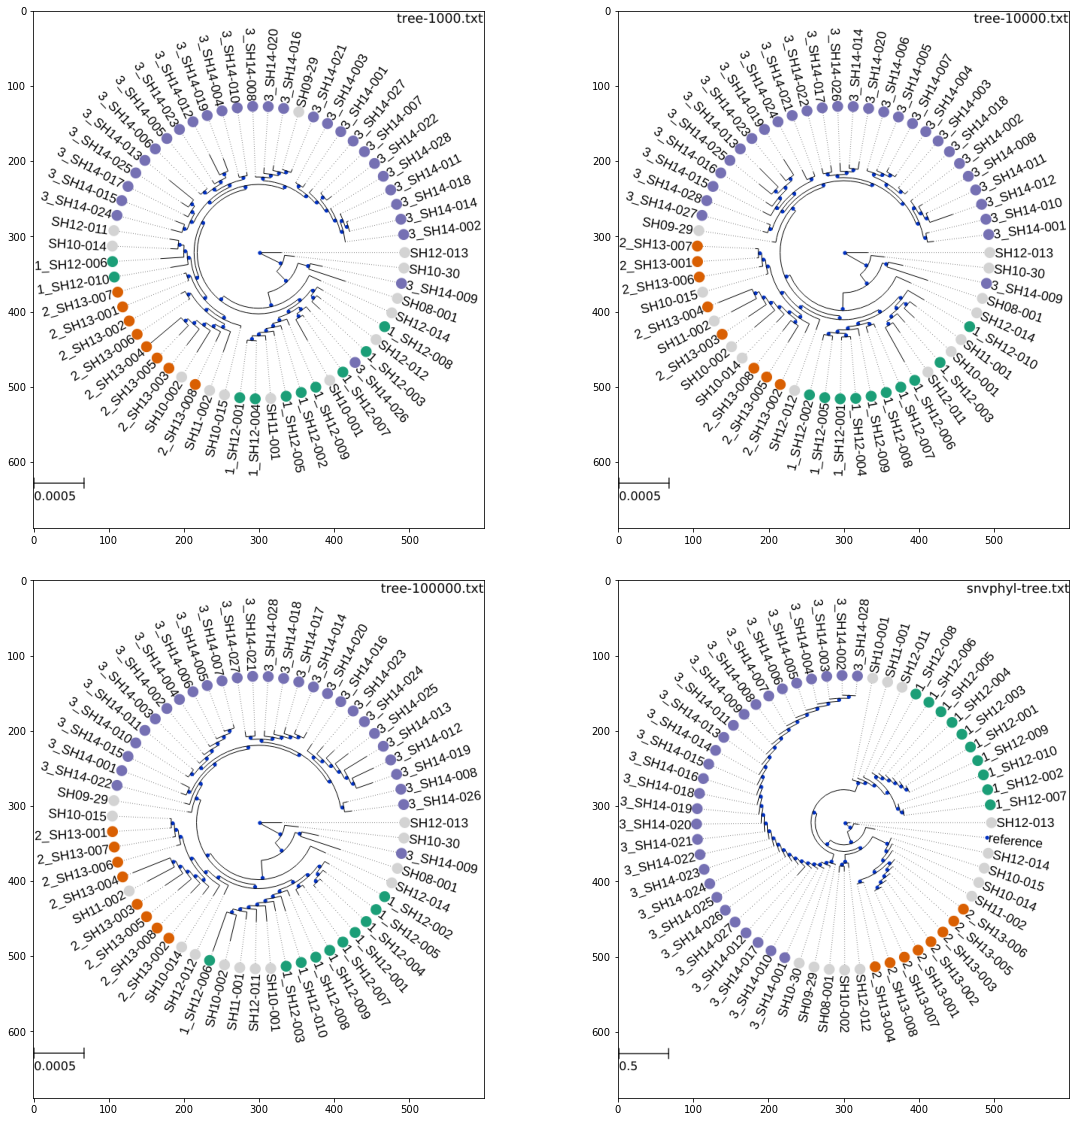

In [3]:
import matplotlib.pyplot as plt
import io

trees = {}
for t in ['tree-1000.txt', 'tree-10000.txt', 'tree-100000.txt',
          'snvphyl-tree.txt', 'tree-10000-21.txt', 'tree-10000-11.txt',
         'mlst-tree.txt', 'sistr-tree.txt']:
    trees[t] = plt.imread(io.BytesIO(get_tree_image(t).data))

f, axarr = plt.subplots(2,2, figsize=(20,20))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
axarr[0,0].imshow(trees['tree-1000.txt'])
axarr[0,1].imshow(trees['tree-10000.txt'])
axarr[1,0].imshow(trees['tree-100000.txt'])
axarr[1,1].imshow(trees['snvphyl-tree.txt'])
# axarr[2,0].imshow(trees['mlst-tree.txt'])
# axarr[2,1].imshow(trees['sistr-tree.txt'])
# axarr[1,1].imshow(trees['tree-10000-21.txt'])
# axarr[1,1].imshow(trees['tree-10000-11.txt'])

plt.show()

# Assemblies

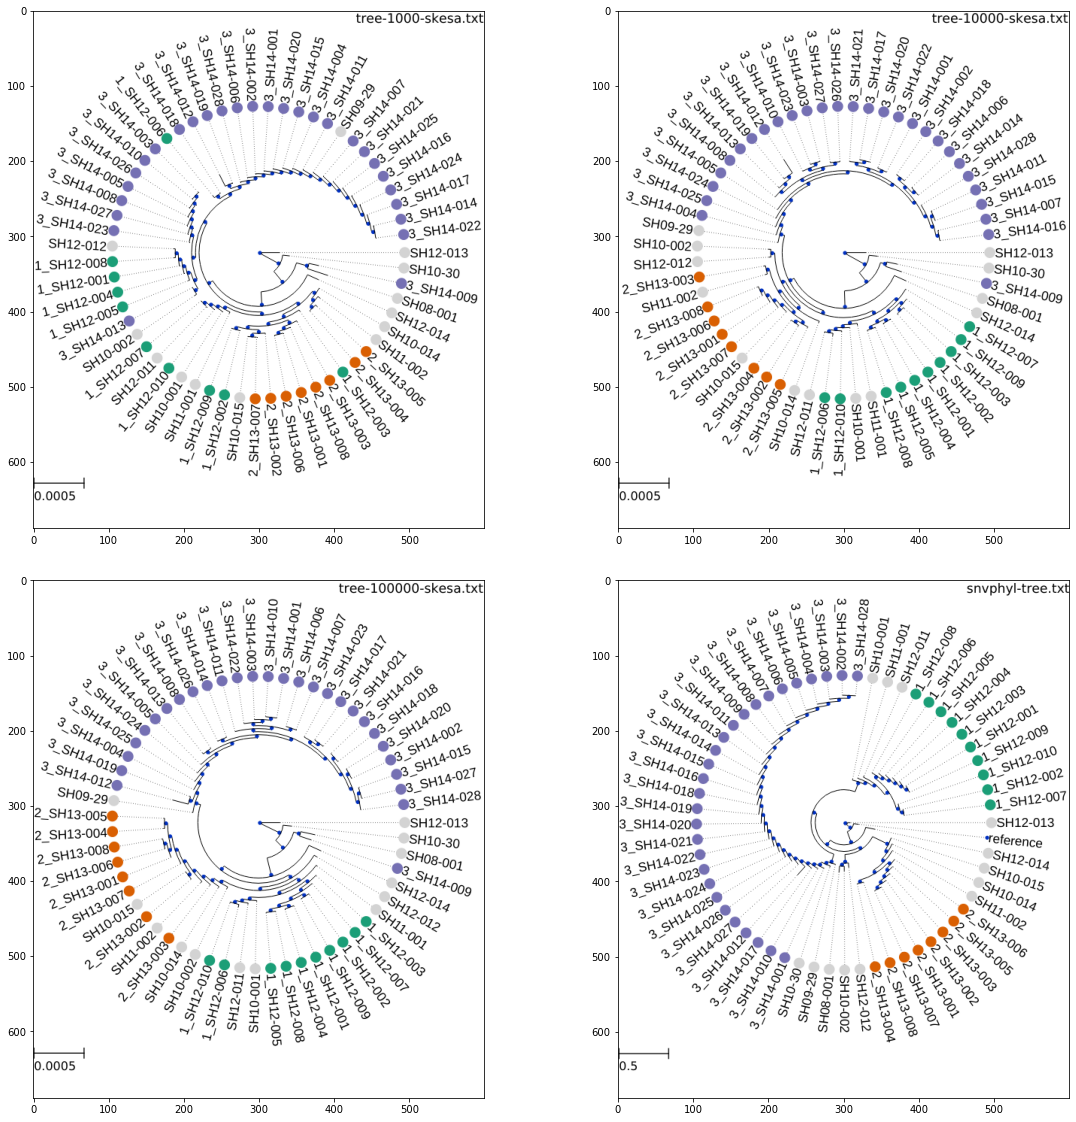

In [4]:
trees = {}
for t in ['tree-1000-skesa.txt', 'tree-10000-skesa.txt', 'tree-100000-skesa.txt', 'snvphyl-tree.txt']:
    trees[t] = plt.imread(io.BytesIO(get_tree_image(t).data))
    
f, axarr = plt.subplots(2,2, figsize=(20,20))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
axarr[0,0].imshow(trees['tree-1000-skesa.txt'])
axarr[0,1].imshow(trees['tree-10000-skesa.txt'])
axarr[1,0].imshow(trees['tree-100000-skesa.txt'])
axarr[1,1].imshow(trees['snvphyl-tree.txt'])

plt.show()

# Iterate over tree

In [5]:
from ete3 import Tree

tree = Tree('tree-1000.txt')
tree.set_outgroup('SH12-013')

for node in tree.traverse("postorder"):
    print(node.name)

SH12-013
SH10-30
SH14-009
SH08-001

SH12-014
SH12-008
SH12-012
SH12-003


SH14-026
SH12-007
SH10-001


SH12-009
SH12-002
SH12-005
SH11-001
SH12-004
SH12-001







SH10-015
SH11-002
SH13-008
SH10-002
SH13-003
SH13-005
SH13-004





SH13-006
SH13-002



SH13-001
SH13-007


SH12-010
SH12-006
SH10-014
SH12-011




SH14-024
SH14-015

SH14-017
SH14-025
SH14-013



SH14-006
SH14-005

SH14-023
SH14-012
SH14-019



SH14-004
SH14-010



SH14-008
SH14-020
SH14-016
SH09-29
SH14-021




SH14-003
SH14-001

SH14-027
SH14-007
SH14-022

SH14-028
SH14-011
SH14-018
SH14-014


SH14-002















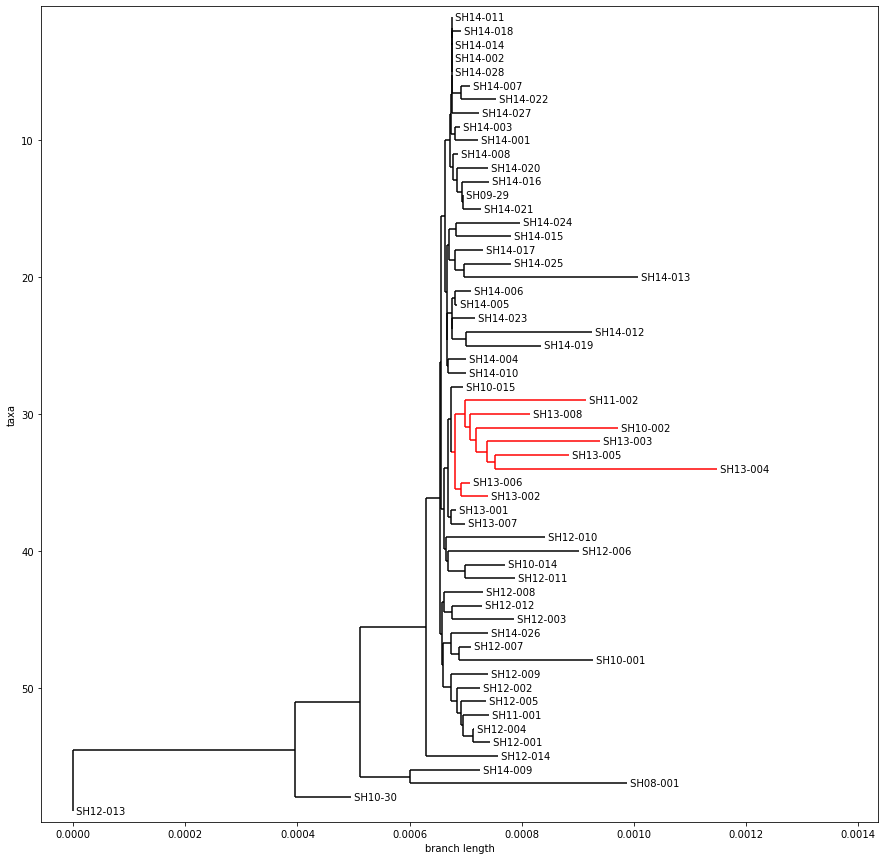

In [6]:
from Bio import Phylo
import matplotlib.pyplot as plt

t = Phylo.read('tree-1000.txt', 'newick')
t.root_with_outgroup('SH12-013')
mrca = t.common_ancestor({'name': 'SH13-006'}, {'name': 'SH13-004'})
mrca.color = 'red'

plt.rcParams['figure.figsize'] = (15,15)
Phylo.draw(t)

# Test evaluate clustering of tree

In [7]:
from typing import Set, Dict, Union, List
from ete3 import Tree, TreeNode
import pandas as pd

def expected_clusters_parser(file: str) -> List[Set]:
    """
    Reads in a file defining expected clusters and returns the names of the genomes.
    
    :param file: The file defining the clusters.
    :return: A list of sets, each set containing names from a particular cluster.
    """
    df = pd.read_csv(file, sep='\t', dtype={'Outbreak number': 'str'}).dropna()
    outbreak_groups = df.groupby('Outbreak number').agg(lambda group: {x for x in group})
    
    return outbreak_groups['Strain'].tolist()

class TreeEvaluation:
    
    def __init__(self, tree: Union[str,TreeNode], score_type: str = 'f-score'):
        if isinstance(tree, str):
            self._tree = Tree(tree)
        else:
            self._tree = tree
        self._score_type = score_type
        
        if score_type not in {'f-score'}:
            raise Exception(f'Invalid score_type=[{score_type}]')

    def max_scoring_clade(self, expected_positives: Set[str]) -> (float, TreeNode, Dict[str,int]):
        root_node = self._tree
        
        all_leaves = {l.name for l in root_node.get_leaves()}

        max_score = 0.0
        max_score_node = None
        max_conf_matrix = None
        for node in self._tree.traverse("postorder"):
            conf_matrix = self._confusion_matrix_treenode(node, expected_positives, all_leaves)
            score = self._get_score(conf_matrix)

            if score > max_score:
                max_score = score
                max_score_node = node
                max_conf_matrix = conf_matrix

        return (max_score, max_score_node, max_conf_matrix)

    def _confusion_matrix_treenode(self, node: TreeNode, expected_positives: Set[str], all_leaves: Set[str]) -> Dict[str,int]:
        found_leaves = {l.name for l in node.get_leaves()}
        true_positives = expected_positives.intersection(found_leaves)
        false_positives = found_leaves - true_positives
        true_negatives = (all_leaves - expected_positives).intersection(all_leaves - found_leaves)
        false_negatives = expected_positives - found_leaves

        return {
            'tp': len(true_positives),
            'fp': len(false_positives),
            'tn': len(true_negatives),
            'fn': len(false_negatives)
        }

    def _get_score(self, confusion_matrix: Dict[str,int]) -> float:
        if self._score_type == 'f-score':
            # Formula from https://en.wikipedia.org/wiki/F-score
            return confusion_matrix['tp'] / (confusion_matrix['tp'] + 0.5 * (confusion_matrix['fp'] + confusion_matrix['fn']))
        else:
            raise Exception(f'Unknown score_type=[{self._score_type}]')

tree_eval = TreeEvaluation('tree-1000.txt', 'f-score')
expected_groups_list = expected_clusters_parser('strain_table.txt')
score, max_clade, confusion_matrix = tree_eval.max_scoring_clade(expected_groups_list[1])
print(score)
print(max_clade)
print(confusion_matrix)

0.8421052631578947

      /-SH10-015
     |
     |      /-SH11-002
     |   /-|
   /-|  |  |   /-SH13-008
  |  |  |   \-|
  |  |  |     |   /-SH10-002
  |  |  |      \-|
  |  |  |        |   /-SH13-003
  |   \-|         \-|
  |     |           |   /-SH13-005
--|     |            \-|
  |     |               \-SH13-004
  |     |
  |     |   /-SH13-006
  |      \-|
  |         \-SH13-002
  |
  |   /-SH13-001
   \-|
      \-SH13-007
{'tp': 8, 'fp': 3, 'tn': 48, 'fn': 0}


In [8]:
def expected_clusters_parser(file: str) -> List[Set]:
    """
    Reads in a file defining expected clusters and returns the names of the genomes.
    
    :param file: The file defining the clusters.
    :return: A list of sets, each set containing names from a particular cluster.
    """
    df = pd.read_csv(file, sep='\t', dtype={'Outbreak number': 'str'})
    outbreak_groups = df.groupby('Outbreak number').agg(lambda group: {x for x in group})
    
    return outbreak_groups['Strain'].tolist()
    
expected_clusters_parser('strain_table.txt')

[{'SH12-001',
  'SH12-002',
  'SH12-003',
  'SH12-004',
  'SH12-005',
  'SH12-006',
  'SH12-007',
  'SH12-008',
  'SH12-009',
  'SH12-010'},
 {'SH13-001',
  'SH13-002',
  'SH13-003',
  'SH13-004',
  'SH13-005',
  'SH13-006',
  'SH13-007',
  'SH13-008'},
 {'SH14-001',
  'SH14-002',
  'SH14-003',
  'SH14-004',
  'SH14-005',
  'SH14-006',
  'SH14-007',
  'SH14-008',
  'SH14-009',
  'SH14-010',
  'SH14-011',
  'SH14-012',
  'SH14-013',
  'SH14-014',
  'SH14-015',
  'SH14-016',
  'SH14-017',
  'SH14-018',
  'SH14-019',
  'SH14-020',
  'SH14-021',
  'SH14-022',
  'SH14-023',
  'SH14-024',
  'SH14-025',
  'SH14-026',
  'SH14-027',
  'SH14-028'}]

In [9]:
eval2 = TreeEvaluation('snvphyl-tree.txt')
score, max_clade, confusion_matrix = eval2.max_scoring_clade({
    'SH12-001',
    'SH12-002',
    'SH12-003',
    'SH12-004',
    'SH12-005',
    'SH12-006',
    'SH12-007',
    'SH12-008',
    'SH12-009',
    'SH12-010',
})
print(score)
print(max_clade)
print(confusion_matrix)

1.0

      /-SH12-008
   /-|
  |  |   /-SH12-006
  |   \-|
  |     |   /-SH12-005
  |      \-|
  |        |   /-SH12-004
  |         \-|
--|           |   /-SH12-003
  |            \-|
  |              |   /-SH12-001
  |               \-|
  |                  \-SH12-009
  |
  |   /-SH12-010
   \-|
     |   /-SH12-002
      \-|
         \-SH12-007
{'tp': 10, 'fp': 0, 'tn': 50, 'fn': 0}


# Evaluate cluster and tree 2

In [10]:
def expected_clusters_parser(file: str) -> Dict[str,Set[str]]:
    """
    Reads in a file defining expected clusters and returns the names of the genomes.
    
    :param file: The file defining the clusters.
    :return: A dictionary of 'cluster name -> set' mappings, each set containing names from a particular cluster.
    """
    df = pd.read_csv(file, sep='\t', dtype={'Outbreak number': 'str'})
    df['Outbreak number'] = df['Outbreak number'].fillna('N/A')
    outbreak_groups = df.groupby('Outbreak number').agg(lambda group: {x for x in group})
    
    clusters = {}
    for name in outbreak_groups['Strain'].index:
        clusters[name] = outbreak_groups['Strain'][name]
    
    return clusters

def construct_dist_dataframe(tree):
    leaves = tree.get_leaves()
    leaf_names = [l.name for l in leaves]

    rows = []
    for i in leaves:
        column = []
        for j in leaves:
            column.append(i.get_distance(j.name))
        rows.append(column)

    return pd.DataFrame(data=rows, columns=leaf_names, index=leaf_names)

def average_dissimilarity(item_name: str, others: Set[str], dissimilarites: pd.DataFrame) -> float:
    """
    Computes the average disimilarity of item_name to all items in the 'others' set minus itself.
    
    :param item_name: The name of the selected item.
    :param others: A set of other names to compare (will ignore itself if it exists in the set).
    :param distances: A dataframe of pairwise dissimilarities.
    
    :return: The average dissimilarity.
    """
    others_minus_item = others - {item_name}
    if len(others_minus_item) == 0:
        raise Exception(f'No items (except {item_name}) in passed others set {others}')
    else:
        total = 0.0
        for other_item in others_minus_item:
            total += dissimilarites[item_name][other_item]
            
        return total/len(others_minus_item)
    
def s_i_neighbor(item: str, cluster_name: str, clusters: Dict[str,Set[str]], dissimilarites: pd.DataFrame) -> (float,str):
    if len(clusters[cluster_name]) == 1:
        return (0.0, None)
    else:
        a_i = average_dissimilarity(item, clusters[cluster_name], dissimilarites)
        other_clusters = set(clusters.keys()) - {cluster_name}

        b_i = None
        b_i_cluster = None
        for c in other_clusters:
            d_i = average_dissimilarity(item, clusters[c], dissimilarites)
            # Find minimum value d_i, becomes b_i
            if (b_i is None) or (d_i < b_i):
                b_i = d_i
                b_i_cluster = c

        if a_i < b_i:
            return (1 - a_i/b_i, b_i_cluster)
        elif a_i > b_i:
            return (b_i/a_i - 1, b_i_cluster)
        else:
            return (0.0, b_i_cluster)

expected_groups_list = expected_clusters_parser('strain_table.txt')

tree = Tree('tree-1000.txt')
tree.unroot()
tree_distances = construct_dist_dataframe(tree)
print(expected_groups_list)
s_i_neighbor('SH13-001', '2', expected_groups_list, tree_distances)

{'1': {'SH12-010', 'SH12-002', 'SH12-008', 'SH12-005', 'SH12-007', 'SH12-001', 'SH12-004', 'SH12-009', 'SH12-006', 'SH12-003'}, '2': {'SH13-005', 'SH13-006', 'SH13-007', 'SH13-008', 'SH13-004', 'SH13-003', 'SH13-001', 'SH13-002'}, '3': {'SH14-009', 'SH14-010', 'SH14-014', 'SH14-017', 'SH14-012', 'SH14-015', 'SH14-026', 'SH14-025', 'SH14-013', 'SH14-019', 'SH14-004', 'SH14-011', 'SH14-005', 'SH14-008', 'SH14-016', 'SH14-021', 'SH14-022', 'SH14-018', 'SH14-007', 'SH14-020', 'SH14-006', 'SH14-002', 'SH14-027', 'SH14-001', 'SH14-003', 'SH14-024', 'SH14-028', 'SH14-023'}, 'N/A': {'SH09-29', 'SH08-001', 'SH12-012', 'SH11-002', 'SH10-30', 'SH10-002', 'SH10-015', 'SH11-001', 'SH12-013', 'SH12-014', 'SH10-014', 'SH12-011', 'SH10-001'}}


(-0.37194217939214236, '3')

In [11]:
item_data = []
for cluster in expected_groups_list:
    for item in expected_groups_list[cluster]:
        (s_i, neighbor) = s_i_neighbor(item, cluster, expected_groups_list, tree_distances)
        item_data.append([item, cluster, neighbor, s_i])

silhouette_df = pd.DataFrame(data=item_data, columns=['item', 'cluster', 'neighbor', 's_i']).set_index('item')
silhouette_df = silhouette_df.sort_values(by=['cluster','s_i'], ascending=[True, False])
silhouette_df.head(5)

,cluster,neighbor,s_i
item,,,
SH12-001,1,3,0.099111
SH12-004,1,3,0.096937
SH12-005,1,3,0.070781
SH12-002,1,3,0.049176
SH12-009,1,3,0.017218


<AxesSubplot:ylabel='item'>

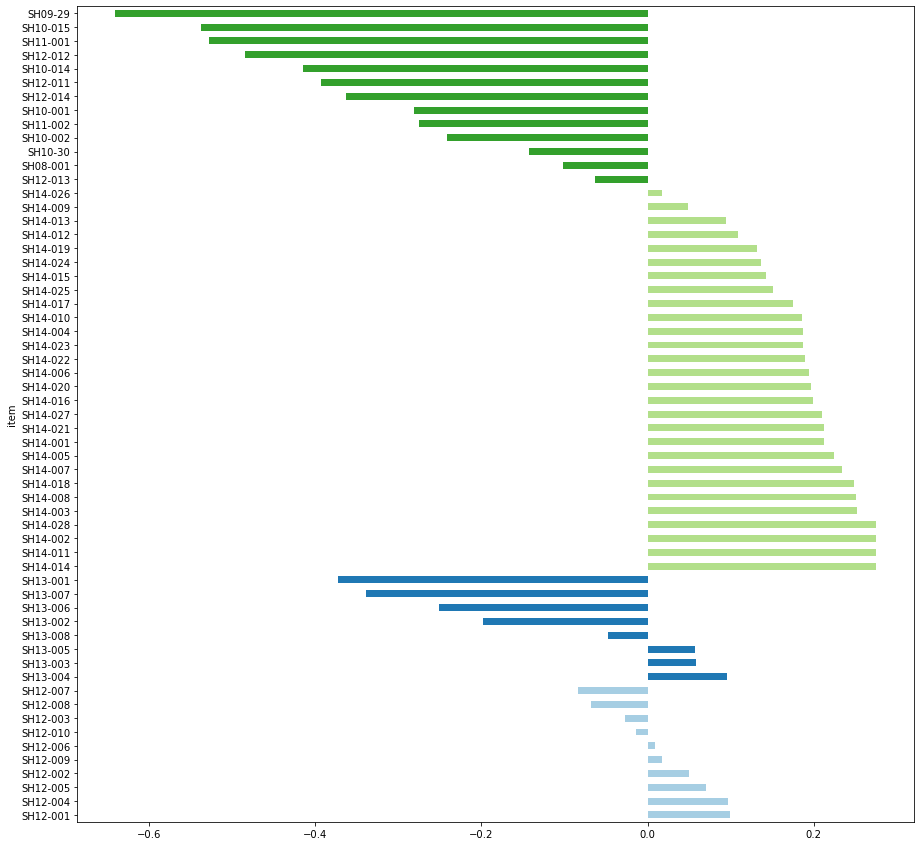

In [12]:
colors = {
    '1': '#a6cee3',
    '2': '#1f78b4',
    '3': '#b2df8a',
    'N/A': '#33a02c'
}
silhouette_df['color'] = silhouette_df['cluster'].apply(lambda x: colors[x])
silhouette_df['s_i'].plot(kind='barh', color=silhouette_df['color'])

In [13]:
silhouette_df['s_i'].mean()

-0.0004228152363474907

# Evaluate tree cluster 3

In [14]:
if 'reference' in tree_distances:
    tree_distances = tree_distances.drop('reference', axis='index').drop('reference', axis='columns')
tree_distances.head(5)

,SH14-028,SH14-007,SH14-022,SH14-027,SH14-003,SH14-001,SH10-015,SH11-002,SH13-008,SH10-002,...,SH14-010,SH14-008,SH14-020,SH14-016,SH09-29,SH14-021,SH14-011,SH14-018,SH14-014,SH14-002
SH14-028,0.000000,0.000033,0.000079,0.000048,0.000016,0.000048,0.000059,0.000277,0.000178,0.000334,...,0.000050,0.000017,0.000070,0.000073,0.000026,0.000058,0.000000,0.000016,0.000000,0.000000
SH14-007,0.000033,0.000000,0.000080,0.000081,0.000049,0.000081,0.000092,0.000310,0.000211,0.000367,...,0.000083,0.000050,0.000103,0.000106,0.000059,0.000091,0.000033,0.000049,0.000033,0.000033
SH14-022,0.000079,0.000080,0.000000,0.000127,0.000095,0.000127,0.000138,0.000356,0.000257,0.000413,...,0.000129,0.000096,0.000149,0.000152,0.000105,0.000137,0.000079,0.000095,0.000079,0.000079
SH14-027,0.000048,0.000081,0.000127,0.000000,0.000064,0.000096,0.000107,0.000325,0.000226,0.000382,...,0.000098,0.000065,0.000118,0.000121,0.000074,0.000106,0.000048,0.000064,0.000048,0.000048
SH14-003,0.000016,0.000049,0.000095,0.000064,0.000000,0.000048,0.000073,0.000291,0.000192,0.000348,...,0.000064,0.000031,0.000084,0.000087,0.000040,0.000072,0.000016,0.000032,0.000016,0.000016


In [15]:
tree_distances_numpy = tree_distances.to_numpy()
tree_distances_numpy

array([[0.0e+00, 3.3e-05, 7.9e-05, ..., 1.6e-05, 0.0e+00, 0.0e+00],
       [3.3e-05, 0.0e+00, 8.0e-05, ..., 4.9e-05, 3.3e-05, 3.3e-05],
       [7.9e-05, 8.0e-05, 0.0e+00, ..., 9.5e-05, 7.9e-05, 7.9e-05],
       ...,
       [1.6e-05, 4.9e-05, 9.5e-05, ..., 0.0e+00, 1.6e-05, 1.6e-05],
       [0.0e+00, 3.3e-05, 7.9e-05, ..., 1.6e-05, 0.0e+00, 0.0e+00],
       [0.0e+00, 3.3e-05, 7.9e-05, ..., 1.6e-05, 0.0e+00, 0.0e+00]])

In [16]:
def expected_clusters_parser(file: str) -> pd.Series:
    """
    Reads in a file defining expected clusters and returns a series.
    
    :param file: The file defining the clusters.
    :return: A series of expected cluster labels and the isolate names.
    """
    df = pd.read_csv(file, sep='\t', dtype={'Outbreak number': 'str'}).set_index('Strain')
    df['Outbreak number'] = df['Outbreak number'].fillna('N/A')
    
    return df['Outbreak number']

expected_clusters = expected_clusters_parser('strain_table.txt')
expected_clusters.head(5)

Strain
SH12-001    1
SH12-002    1
SH12-003    1
SH12-004    1
SH12-005    1
Name: Outbreak number, dtype: object

In [17]:
ordered_cluster_labels = expected_clusters[tree_distances.index].to_numpy()
ordered_cluster_labels

array(['3', '3', '3', '3', '3', '3', 'N/A', 'N/A', '2', 'N/A', '2', '2',
       '2', '2', '2', '2', '2', '1', '1', 'N/A', 'N/A', 'N/A', 'N/A',
       'N/A', '3', 'N/A', '1', 'N/A', '1', '3', '1', 'N/A', '1', '1', '1',
       'N/A', '1', '1', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3',
       '3', '3', '3', '3', '3', 'N/A', '3', '3', '3', '3', '3'],
      dtype=object)

In [18]:
from sklearn import metrics
metrics.silhouette_score(tree_distances_numpy, ordered_cluster_labels, metric='precomputed')

-0.00042281523634750005

<Figure size 1080x1080 with 0 Axes>

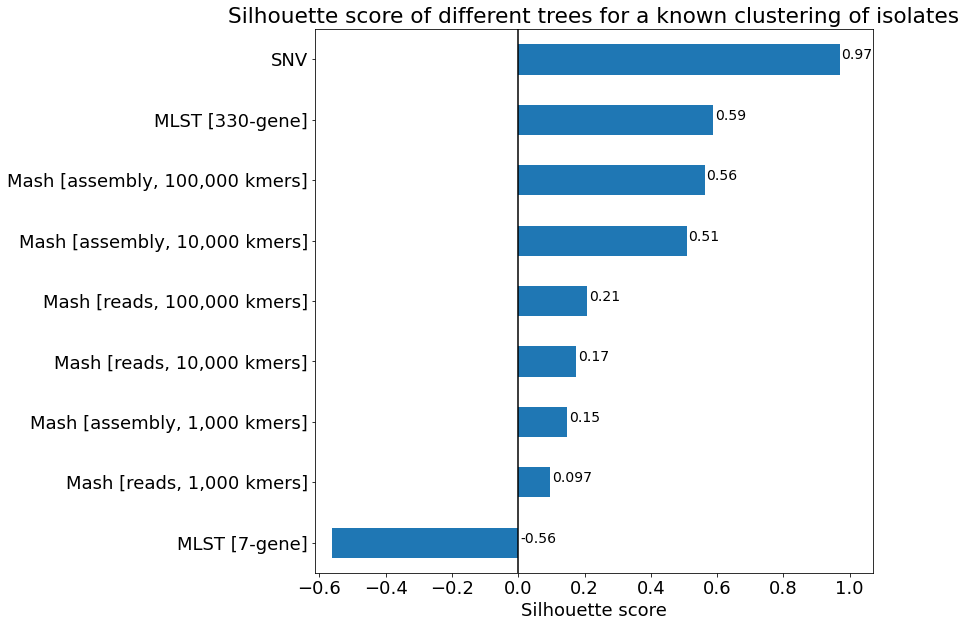

In [19]:
from typing import List
import pandas as pd
from sklearn import metrics
from ete3 import Tree
import matplotlib.pyplot as plt

def expected_clusters_parser(file: str) -> pd.Series:
    """
    Reads in a file defining expected clusters and returns a series.
    
    :param file: The file defining the clusters.
    :return: A series of expected cluster labels and the isolate names.
    """
    df = pd.read_csv(file, sep='\t', dtype={'Outbreak number': 'str'}).set_index('Strain')
            
    return df['Outbreak number']

class ClusterToTreeEvaluator:
    
    def __init__(self, clusters: pd.Series):
        self._clusters = clusters
        
    def evaluate(self, tree: TreeNode, exclude_isolates: List[str] = None):
        pass
            
class ClusterToTreeEvaluatorSilhouette(ClusterToTreeEvaluator):
    
    def __init__(self, clusters: pd.Series):
        super().__init__(clusters)
                
    def _construct_dist_dataframe(self, tree: TreeNode) -> pd.DataFrame:
        leaves = tree.get_leaves()
        leaf_names = [l.name for l in leaves]

        rows = []
        for i in leaves:
            column = []
            for j in leaves:
                column.append(i.get_distance(j.name))
            rows.append(column) 
        
        return pd.DataFrame(data=rows, columns=leaf_names, index=leaf_names)
        
    def evaluate(self, tree: TreeNode, exclude_isolates: List[str] = None):
        tree_distances = self._construct_dist_dataframe(tree)
        if exclude_isolates is not None:
            for excluded in exclude_isolates:
                if excluded in tree_distances:
                    tree_distances = tree_distances.drop(excluded, axis='index').drop(excluded, axis='columns')
            
        tree_distances_numpy = tree_distances.to_numpy()
        ordered_cluster_labels = self._clusters[tree_distances.index].to_numpy()
        
        return metrics.silhouette_score(tree_distances_numpy,
                                        ordered_cluster_labels,
                                        metric='precomputed')
    
def evaluate_all_trees(tree_evaluator: ClusterToTreeEvaluator, tree_files: List[str],
                       exclude_isolates: List[str]) -> pd.DataFrame:
    scores = []
    
    for file in tree_files:
        tree = Tree(file)
        tree.unroot()
        score = tree_evaluator.evaluate(tree, exclude_isolates=exclude_isolates)
        scores.append(score)
        
    return pd.DataFrame(data=scores, columns=['silhouette'], index=tree_files)
    
expected_clusters = expected_clusters_parser('strain_table.txt')
unclustered_isolates = expected_clusters[expected_clusters.isna()].index.tolist()
expected_clusters = expected_clusters.dropna()
tree_evaluator = ClusterToTreeEvaluatorSilhouette(expected_clusters)

tree_scores = evaluate_all_trees(tree_evaluator=tree_evaluator,
                   tree_files=['tree-1000.txt', 'tree-10000.txt', 'tree-100000.txt', 'snvphyl-tree.txt',
                              'tree-1000-skesa.txt', 'tree-10000-skesa.txt', 'tree-100000-skesa.txt',
                              'mlst-tree.txt', 'sistr-tree.txt'],
                   exclude_isolates=['reference'] + unclustered_isolates
                  )

tree_scores = tree_scores.sort_values('silhouette')

tree_scores['label'] = None
tree_scores.loc['snvphyl-tree.txt', 'label'] = 'SNV'
tree_scores.loc['tree-1000.txt', 'label'] = 'Mash [reads, 1,000 kmers]'
tree_scores.loc['tree-10000.txt', 'label'] = 'Mash [reads, 10,000 kmers]'
tree_scores.loc['tree-100000.txt', 'label'] = 'Mash [reads, 100,000 kmers]'
tree_scores.loc['tree-1000-skesa.txt', 'label'] = 'Mash [assembly, 1,000 kmers]'
tree_scores.loc['tree-10000-skesa.txt', 'label'] = 'Mash [assembly, 10,000 kmers]'
tree_scores.loc['tree-100000-skesa.txt', 'label'] = 'Mash [assembly, 100,000 kmers]'
tree_scores.loc['mlst-tree.txt', 'label'] = 'MLST [7-gene]'
tree_scores.loc['sistr-tree.txt', 'label'] = 'MLST [330-gene]'
tree_scores = tree_scores.set_index('label')
plt.figure()
plt.rcParams.update({'font.size': 18})
tree_scores.plot(kind='barh', figsize=(10,10), legend=False)
scores_list = tree_scores['silhouette'].tolist()
scores_list.append(0)
ax = plt.gca()
plt.xlim(min(scores_list)-0.05, max(scores_list) + 0.1)
plt.xlabel('Silhouette score')
plt.ylabel('')
plt.title('Silhouette score of different trees for a known clustering of isolates')
ax.axvline(color='black')
for i, v in enumerate(tree_scores['silhouette']):
    if v < 0:
        pos = 0 + 0.005
    else:
        pos = v + 0.005
    ax.text(pos, i, f'{v:.2}', fontsize=14)

# Evaluate tree cluster 4

In [20]:
from typing import List
import pandas as pd
from sklearn import metrics
from ete3 import Tree
import matplotlib.pyplot as plt

def expected_clusters_parser(file: str) -> pd.Series:
    """
    Reads in a file defining expected clusters and returns a series.
    
    :param file: The file defining the clusters.
    :return: A series of expected cluster labels and the isolate names.
    """
    df = pd.read_csv(file, sep='\t', dtype={'Outbreak number': 'str'}).set_index('Strain')
            
    return df['Outbreak number']

expected_clusters = expected_clusters_parser('strain_table.txt')
unclustered_isolates = expected_clusters[expected_clusters.isna()].index.tolist()
expected_clusters = expected_clusters.dropna()
expected_clusters

Strain
SH12-001    1
SH12-002    1
SH12-003    1
SH12-004    1
SH12-005    1
SH12-006    1
SH12-007    1
SH12-008    1
SH12-009    1
SH12-010    1
SH13-001    2
SH13-002    2
SH13-003    2
SH13-004    2
SH13-005    2
SH13-006    2
SH13-007    2
SH13-008    2
SH14-001    3
SH14-002    3
SH14-003    3
SH14-004    3
SH14-005    3
SH14-006    3
SH14-007    3
SH14-008    3
SH14-009    3
SH14-010    3
SH14-011    3
SH14-012    3
SH14-013    3
SH14-014    3
SH14-015    3
SH14-016    3
SH14-017    3
SH14-018    3
SH14-019    3
SH14-020    3
SH14-021    3
SH14-022    3
SH14-023    3
SH14-024    3
SH14-025    3
SH14-026    3
SH14-027    3
SH14-028    3
Name: Outbreak number, dtype: object

In [21]:
def proportion_monophyletic_tree(tree: Tree, expected_clusters: pd.Series) -> float:
    count_monophyletic = 0
    
    cluster_names = expected_clusters.value_counts().index.tolist()
    for name in cluster_names:
        cluster = expected_clusters[expected_clusters == name].index
        (monophyly, value, node) = tree.check_monophyly(cluster, target_attr='name')
        if monophyly:
            count_monophyletic += 1
            
    return count_monophyletic/len(cluster_names)

def monophyletic_all_trees(tree_files: List[Tree], tree_labels: List[str], expected_clusters: pd.Series) -> pd.DataFrame:
    proportions = []
    for file in tree_files:
        tree = Tree(file)
        proportions.append(proportion_monophyletic_tree(tree, expected_clusters))
    
    print(tree_labels)
    return pd.DataFrame(data={'proportion': proportions, 'label': tree_labels}, index=tree_files)

files = ['tree-1000.txt', 'tree-10000.txt', 'tree-100000.txt', 'snvphyl-tree.txt',
         'tree-1000-skesa.txt', 'tree-10000-skesa.txt', 'tree-100000-skesa.txt',
         'mlst-tree.txt', 'sistr-tree.txt']
labels = ['Mash [reads, 1,000 kmers]', 'Mash [reads, 10,000 kmers]', 'Mash [reads, 100,000 kmers]','SNV',
          'Mash [assembly, 1,000 kmers]', 'Mash [assembly, 10,000 kmers]', 'Mash [assembly, 100,000 kmers]',
          'MLST [7-gene]' ,'MLST [330-gene]',
         ]
monophyletic_all_trees(files, labels, expected_clusters)

['Mash [reads, 1,000 kmers]', 'Mash [reads, 10,000 kmers]', 'Mash [reads, 100,000 kmers]', 'SNV', 'Mash [assembly, 1,000 kmers]', 'Mash [assembly, 10,000 kmers]', 'Mash [assembly, 100,000 kmers]', 'MLST [7-gene]', 'MLST [330-gene]']


,proportion,label
tree-1000.txt,0.0,"Mash [reads, 1,000 kmers]"
tree-10000.txt,0.0,"Mash [reads, 10,000 kmers]"
tree-100000.txt,0.0,"Mash [reads, 100,000 kmers]"
snvphyl-tree.txt,1.0,SNV
tree-1000-skesa.txt,0.0,"Mash [assembly, 1,000 kmers]"
tree-10000-skesa.txt,0.0,"Mash [assembly, 10,000 kmers]"
tree-100000-skesa.txt,0.0,"Mash [assembly, 100,000 kmers]"
mlst-tree.txt,0.0,MLST [7-gene]
sistr-tree.txt,0.0,MLST [330-gene]


# Evaluate tree cluster 5

<Figure size 1080x1080 with 0 Axes>

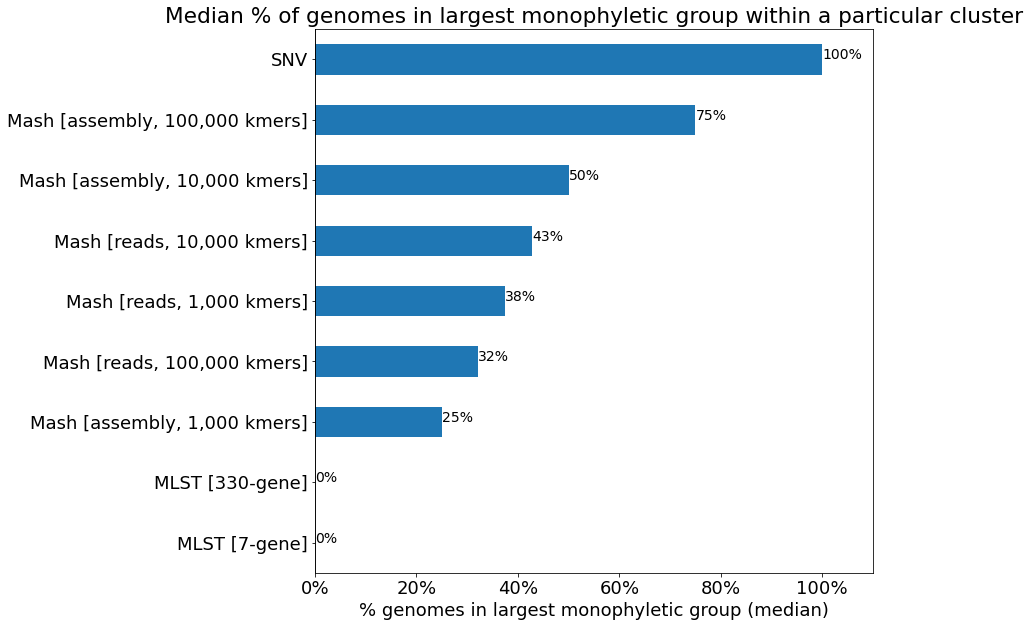

In [42]:
import numpy as np
import matplotlib.ticker as mtick

def mean_largest_monophyletic_percent(tree: Tree, expected_clusters: pd.Series) -> float:
    proportion_monophyletic = []
    
    cluster_names = expected_clusters.value_counts().index.tolist()
    for name in cluster_names:
        largest_monophyletic = set()
        cluster = set(expected_clusters[expected_clusters == name].index.tolist())
        for node in tree.traverse("levelorder"):
            leaves = {l.name for l in node.get_leaves()}
            leaves_in_cluster = cluster.intersection(leaves)
            if len(leaves_in_cluster) > len(largest_monophyletic):
                (monophyly, value, node) = tree.check_monophyly(leaves_in_cluster, target_attr='name')
                if monophyly:
                    largest_monophyletic = leaves_in_cluster
        proportion_monophyletic.append(100 * len(largest_monophyletic)/len(cluster))
        
    return np.median(proportion_monophyletic)

def monophyletic_all_trees(tree_files: List[Tree], tree_labels: List[str], expected_clusters: pd.Series) -> pd.DataFrame:
    percents = []
    for file in tree_files:
        tree = Tree(file)
        percents.append(mean_largest_monophyletic_percent(tree, expected_clusters))
    
    return pd.DataFrame(data={'percent': percents, 'label': tree_labels}, index=tree_files)

files = ['tree-1000.txt', 'tree-10000.txt', 'tree-100000.txt', 'snvphyl-tree.txt',
         'tree-1000-skesa.txt', 'tree-10000-skesa.txt', 'tree-100000-skesa.txt',
         'mlst-tree.txt', 'sistr-tree.txt']
labels = ['Mash [reads, 1,000 kmers]', 'Mash [reads, 10,000 kmers]', 'Mash [reads, 100,000 kmers]','SNV',
          'Mash [assembly, 1,000 kmers]', 'Mash [assembly, 10,000 kmers]', 'Mash [assembly, 100,000 kmers]',
          'MLST [7-gene]' ,'MLST [330-gene]',
         ]
mono_scores = monophyletic_all_trees(files, labels, expected_clusters)
mono_scores = mono_scores.sort_values('percent').set_index('label')

plt.figure()
mono_scores.plot(kind='barh', figsize=(10,10), legend=False)
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlim(0, 100 + 10)
plt.xlabel('% genomes in largest monophyletic group (median)')
plt.ylabel('')
plt.title('Median % of genomes in largest monophyletic group within a particular cluster')
ax.axvline(color='black')
for i, v in enumerate(mono_scores['percent']):
    if v < 0:
        pos = 0 + 0.005
    else:
        pos = v + 0.005
    ax.text(pos, i, f'{v:.0f}%', fontsize=14)